# Picking Diverse Molecules Using Fingerprints

In [60]:
import pandas as pd
ligands = pd.read_csv('sample_ligands.csv', index_col=False)['canonical_SMILES'].values.tolist()

In [61]:
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
ms = [Chem.MolFromSmiles(x) for x in ligands]
while ms.count(None): ms.remove(None)
fps = [GetMorganFingerprint(x,3) for x in ms]
nfps = len(fps)

In [62]:
def distij(i,j,fps=fps):
    return 1-DataStructs.DiceSimilarity(fps[i],fps[j])

In [63]:
picker = MaxMinPicker()
pickIndices = picker.LazyPick(distij,nfps,9,seed=23)
list(pickIndices)

[51, 91, 44, 63, 5, 55, 48, 77, 89]

In [21]:
picks = [ms[x] for x in pickIndices]

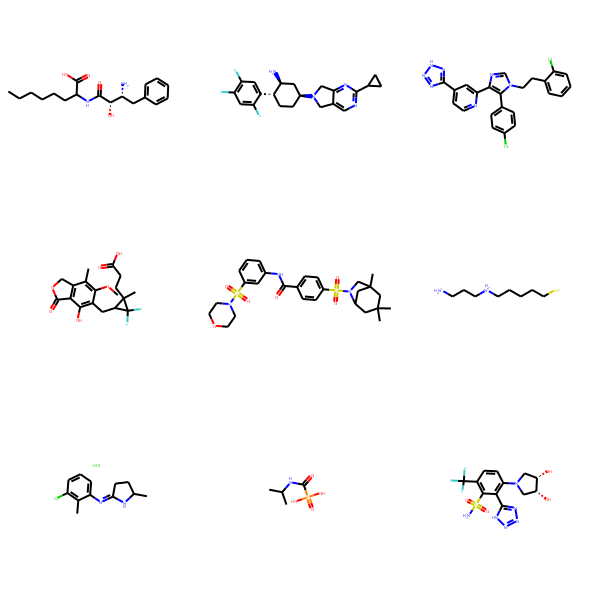

In [22]:
Draw.MolsToGridImage(picks)

# Generating Similarity Maps Using Fingerprints

In [2]:
from rdkit import Chem
mol = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
refmol = Chem.MolFromSmiles('CCCN(CCCCN1CCN(c2ccccc2OC)CC1)Cc1ccc2ccccc2c1')

In [3]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
fp = SimilarityMaps.GetAPFingerprint(mol, fpType='normal')
fp = SimilarityMaps.GetTTFingerprint(mol, fpType='normal')
fp = SimilarityMaps.GetMorganFingerprint(mol, fpType='bv')

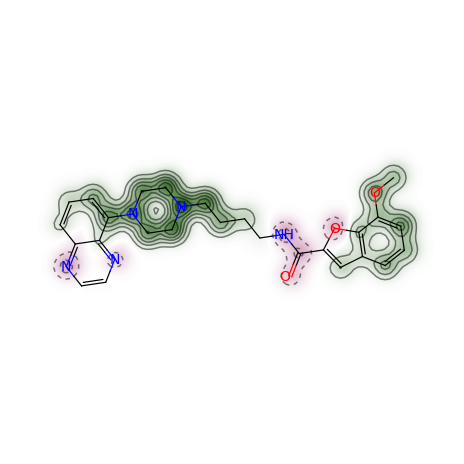

In [4]:
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, SimilarityMaps.GetMorganFingerprint)

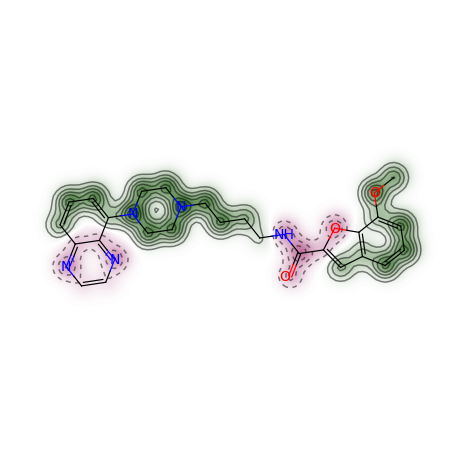

In [5]:
from rdkit import DataStructs
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, lambda m,idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=1, fpType='count'), metric=DataStructs.TanimotoSimilarity)

# Highlighting graphs

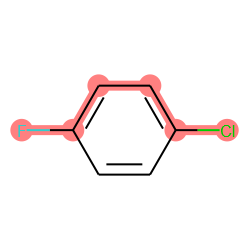

In [23]:
from rdkit.Chem.Draw import rdMolDraw2D
from io import BytesIO
from PIL import Image
smi = 'c1cc(F)ccc1Cl'
mol = Chem.MolFromSmiles(smi)
patt = Chem.MolFromSmarts('ClccccF')
hit_ats = list(mol.GetSubstructMatch(patt))
hit_bonds = []
for bond in patt.GetBonds():
    aid1 = hit_ats[bond.GetBeginAtomIdx()]
    aid2 = hit_ats[bond.GetEndAtomIdx()]
    hit_bonds.append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())
d = rdMolDraw2D.MolDraw2DCairo(250, 250) # or MolDraw2DCairo to get PNGs
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=hit_ats,
                                   highlightBonds=hit_bonds)
d.FinishDrawing()
png = d.GetDrawingText()
bio = BytesIO(png)
img = Image.open(bio)   
img

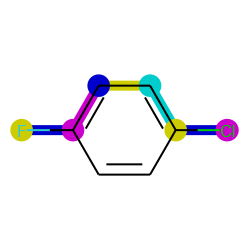

In [24]:
colours = [(0.8,0.0,0.8),(0.8,0.8,0),(0,0.8,0.8),(0,0,0.8)]
atom_cols = {}
for i, at in enumerate(hit_ats):
    atom_cols[at] = colours[i%4]
bond_cols = {}
for i, bd in enumerate(hit_bonds):
    bond_cols[bd] = colours[3 - i%4]

d = rdMolDraw2D.MolDraw2DCairo(250, 250)
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=hit_ats,
                                   highlightAtomColors=atom_cols,
                                   highlightBonds=hit_bonds,
                                   highlightBondColors=bond_cols)
d.FinishDrawing()
png = d.GetDrawingText()
bio = BytesIO(png)
img = Image.open(bio)   
img

## Highlighting functional groups
[iwatobipen's blog](https://iwatobipen.wordpress.com/2020/05/11/molecules-drawing-code-memo-highlight-functional-groups-memo/)

In [47]:
import os
from rdkit import Chem
from rdkit.Chem import FunctionalGroups
from rdkit.Chem import RDConfig
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from IPython.display import display
AllChem.SetPreferCoordGen(True)

In [49]:
mols = [Chem.MolFromSmiles(x) for x in ligands]
for mol in mols:
    AllChem.Compute2DCoords(mol)

methyl amide


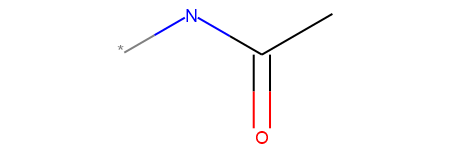

carboxylic acids


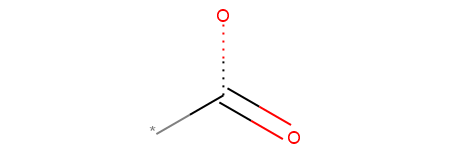

carbonyl methyl ester


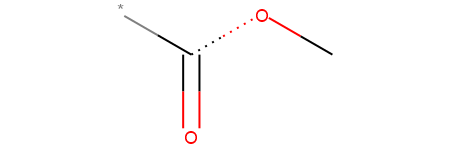

terminal aldehyde


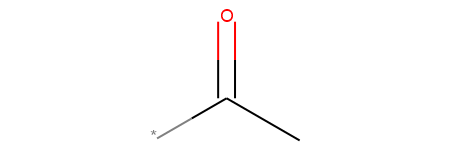

amide


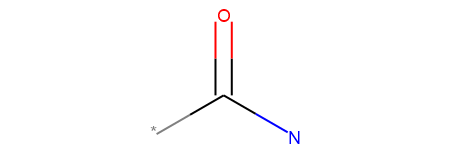

carbonyl methyl


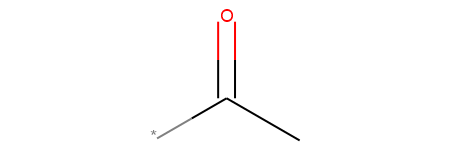

isocyanate


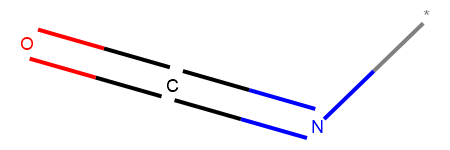

isothiocyanate


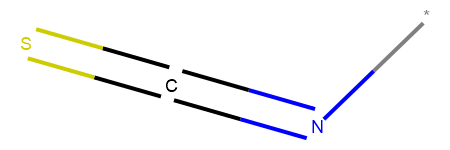

nitro


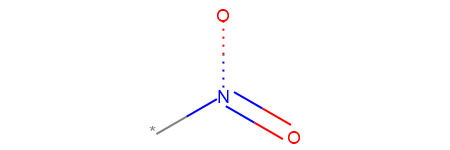

nitroso


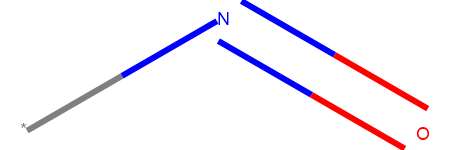

oximes


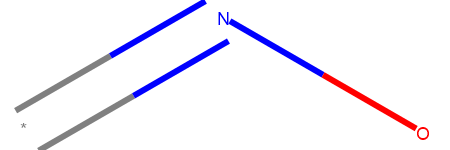

Imines


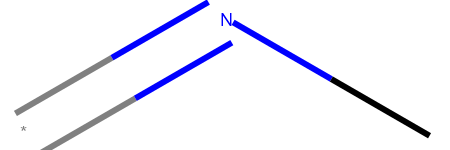

Imines


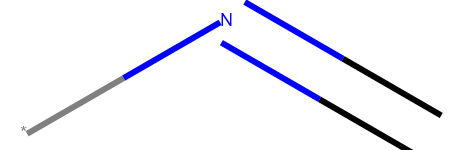

terminal azo


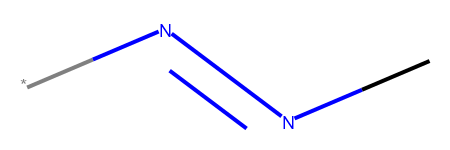

hydrazines


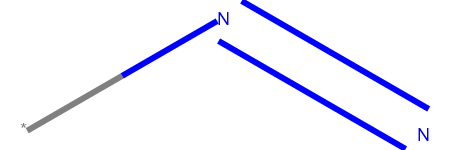

diazo


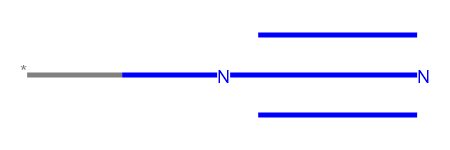

cyano


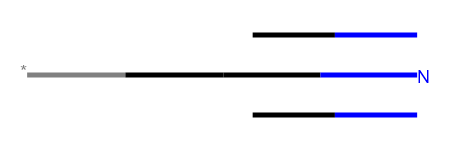

primary sulfonamide


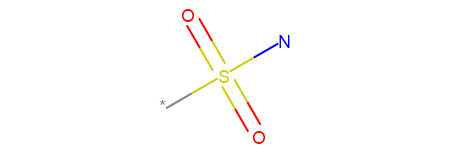

methyl sulfonamide


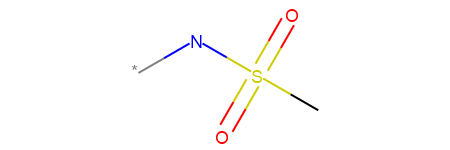

sulfonic acid


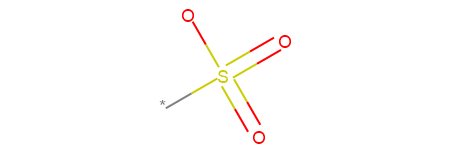

methyl ester sulfonyl


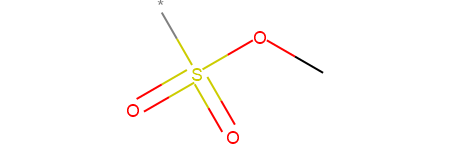

methyl sulfonyl


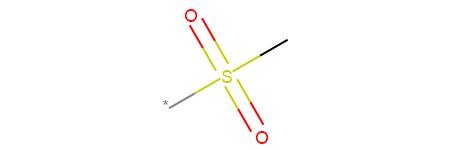

sulfonyl chloride


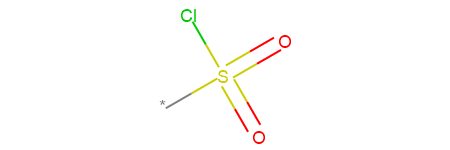

methyl sulfinyl


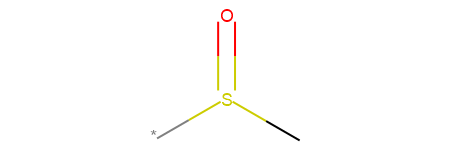

methylthio


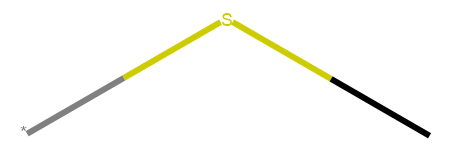

thiols


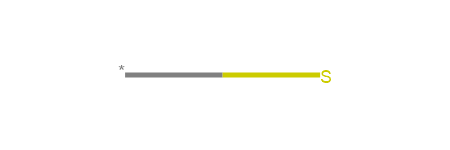

thiocarbonyls


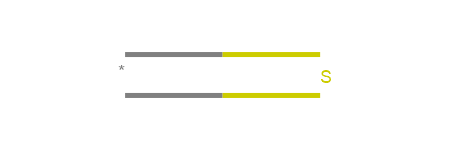

halogens


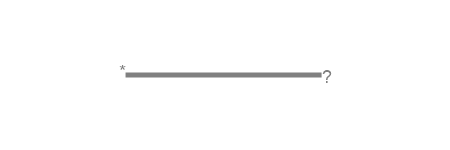

t-butyl


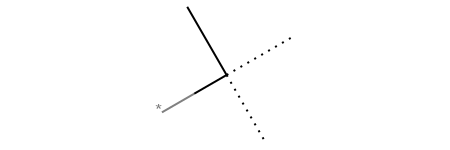

trifluoromethyl


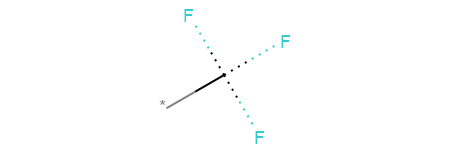

acetylenes


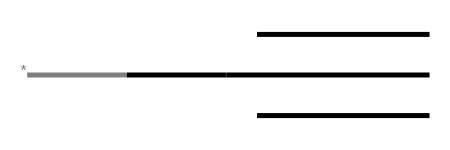

cyclopropyl


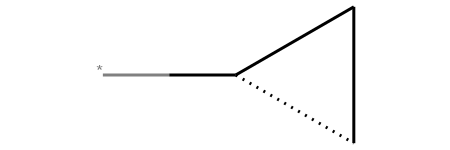

ethoxy


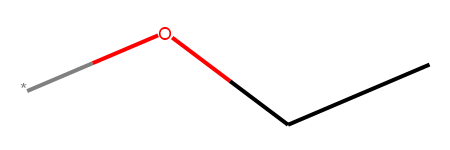

methoxy


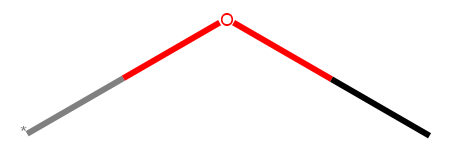

side-chain hydroxyls


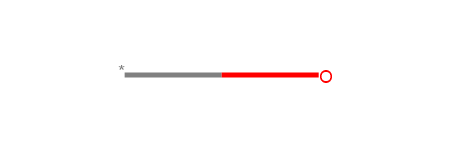

side-chain aldehydes or ketones


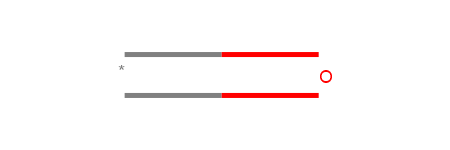

primary amines


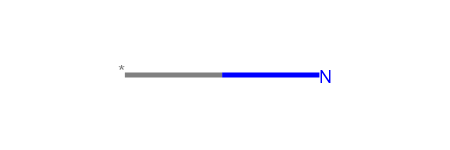

???


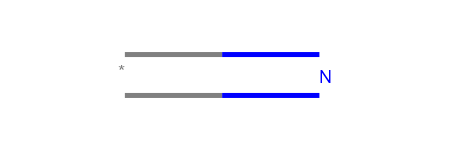

nitriles


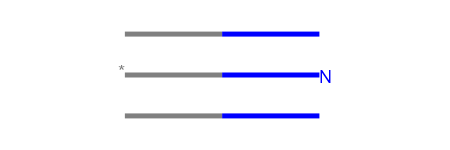

In [50]:
fName = os.path.join(RDConfig.RDDataDir, 'FunctionalGroups.txt')
catparams =FunctionalGroups.BuildFuncGroupHierarchy(fileNm=fName)

for param in catparams:
    print(param.name)
    param.pattern.UpdatePropertyCache(strict=False)
    Chem.FastFindRings(param.pattern)
    Chem.SetHybridization(param.pattern)
    display(param.pattern)

In [57]:
def rendermols(mols):
    d2d = rdMolDraw2D.MolDraw2DSVG(600, 600, 300, 300)
    d2d.drawOptions().setHighlightColour((0.6,0.6,1.0))
    alllists = []
    for mol in mols:
        highlightatms = []
        for param in catparams:
            matches = mol.GetSubstructMatches(param.pattern)
            for match in matches:
                for atm in match:
                    highlightatms.append(atm)
        alllists.append(highlightatms)
    #d2d.DrawMolecules(mols, highlightAtoms=alllists)
    d2d.DrawMolecules(mols, highlightAtoms=alllists)
    d2d.FinishDrawing()
    return d2d.GetDrawingText()


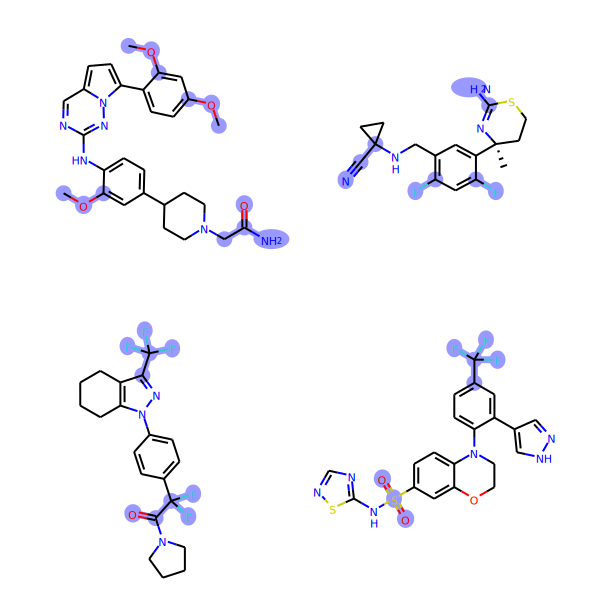

In [59]:
res = rendermols(mols[:4])
SVG(res)

## Scaffold Network
[RDKit Blog Notebook](https://github.com/greglandrum/rdkit_blog/blob/master/notebooks/Scaffold%20Network%20%20Interactive%20Views%20and%20Exploring%20the%20Options.ipynb)

In [27]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.maxFontSize=18
from rdkit.Chem import rdDepictor
from urllib import parse
from rdkit.Chem.Draw import rdMolDraw2D
import gzip
import time
import rdkit
import logging
from rdkit import RDLogger
from rdkit.Chem.Scaffolds import rdScaffoldNetwork

print(rdkit.__version__)
%load_ext sql
%pylab inline

2020.03.6
The sql module is not an IPython extension.
Populating the interactive namespace from numpy and matplotlib


In [32]:
moldict = dict((x, Chem.MolFromSmiles(x)) for x in ligands)
len(moldict)

100

In [33]:
ms = list(moldict.values())

In [34]:
from rdkit.Chem.Draw import rdMolDraw2D
import networkx as nx
from networkx.readwrite import cytoscape_data
from urllib import parse

# some code borrowed from pen: 
# https://iwatobipen.wordpress.com/2020/03/30/draw-scaffold-tree-as-network-with-molecular-image-rdkit-cytoscape/
def smi2svg(smi):
    mol = Chem.MolFromSmiles(smi)
    try:
        Chem.rdmolops.Kekulize(mol)
    except:
        pass
    drawer = rdMolDraw2D.MolDraw2DSVG(350, 300)
    rdMolDraw2D.PrepareAndDrawMolecule(drawer,mol)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg
  
def smi2image(smi):
    svg_string = smi2svg(smi)
    impath = 'data:image/svg+xml;charset=utf-8,' + parse.quote(svg_string, safe="")
    return impath

In [46]:
import ipycytoscape
import ipywidgets as widgets
from ipywidgets import interact,fixed


tms = ms[:50]
def show_scaffolds(mols, which=None,layout='dagre',includeGenericScaffolds=False,includeGenericBondScaffolds=False,
                   includeScaffoldsWithAttachments=True,includeScaffoldsWithoutAttachments=False,
                   pruneBeforeFragmenting=True,
                  keepOnlyFirstFragment=True):
    # the scaffold generation process is verbose, disable the messages sent to the info log:
    #RDLogger.DisableLog('rdApp.info')

    if which is not None:
        mols = [mols[which]]
    scaffParams = rdScaffoldNetwork.ScaffoldNetworkParams()
    scaffParams.collectMolCounts = True
    scaffParams.includeGenericScaffolds = includeGenericScaffolds
    scaffParams.includeScaffoldsWithoutAttachments = includeScaffoldsWithoutAttachments
    scaffParams.keepOnlyFirstFragment = keepOnlyFirstFragment
    scaffParams.includeGenericBondScaffolds = includeGenericBondScaffolds
    scaffParams.includeScaffoldsWithAttachments = includeScaffoldsWithAttachments
    scaffParams.pruneBeforeFragmenting = pruneBeforeFragmenting
    net = rdScaffoldNetwork.CreateScaffoldNetwork(mols, scaffParams)
    g = nx.graph.Graph()
    for idx, node in enumerate(net.nodes):
        print(node)
        

        g.add_node(idx, 
                   #count=f'count: {net.molCounts[idx]}', 
                   smiles=node, img=smi2image(node), hac=Chem.MolFromSmiles(node).GetNumAtoms())
    g.add_edges_from([(e.beginIdx,e.endIdx) for e in net.edges])
    
    directed = ipycytoscape.CytoscapeWidget()
    directed.set_style([{
                            'selector': 'node',
                            'css': {
                                'content': 'data(count)',
                                'text-valign': 'top',
                                'color': 'white',
                                'text-outline-width': 2,
                                'text-outline-color': '#9dbaea',
                                'shape' : 'rectangle',
                                'width':350,
                                'height':300,
                                'background-color': '#9dbaea',
                                'background-fit':'contain',
                                'background-image':'data(img)',

                            }
                            },
                            {
                            'selector': 'edge',
                            'style': {
                                'width': 4,
                                'line-color': '#9dbaea',
                                'target-arrow-shape': 'triangle',
                                'target-arrow-color': '#9dbaea',
                                'curve-style': 'bezier'
                            }
                            },
                            {
                            'selector': ':selected',
                            'css': {
                                'background-color': 'black',
                                'line-color': 'black',
                                'target-arrow-color': 'black',
                                'source-arrow-color': 'black',
                                'text-outline-color': 'black'
                            }}
                            ])
    directed.set_layout(name=layout, nodeSpacing=50, edgeLengthVal=50)
    directed.graph.add_graph_from_networkx(g, directed=True)
    return directed


@interact(mols=fixed(tms), which=range(0, len(tms)), layout=['dagre', 'breadthfirst', 'concentric', 'cose'])
def interactively_show_scaffolds(mols, which=None,layout='dagre',includeGenericScaffolds=False,includeGenericBondScaffolds=False,
                   includeScaffoldsWithAttachments=True,includeScaffoldsWithoutAttachments=False,
                   pruneBeforeFragmenting=True,
                  keepOnlyFirstFragment=True):
    # the scaffold generation process is verbose, disable the messages sent to the info log:
    #RDLogger.DisableLog('rdApp.info')

    if which is None:
        return
    return show_scaffolds(mols, which=which, layout=layout,includeGenericScaffolds=includeGenericScaffolds,
                          includeGenericBondScaffolds=includeGenericBondScaffolds,
                          includeScaffoldsWithAttachments=includeScaffoldsWithAttachments,
                         includeScaffoldsWithoutAttachments=includeScaffoldsWithoutAttachments,
                         pruneBeforeFragmenting=pruneBeforeFragmenting,keepOnlyFirstFragment=keepOnlyFirstFragment)        

interactive(children=(Dropdown(description='which', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…